<a href="https://colab.research.google.com/github/detsutut/AraucanaXAI/blob/master/araucana_CLEF_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CLEF Pipeline**

# **Init**

In [1]:
%%capture
!pip3 install shap
!pip3 install araucanaxai
!pip3 install lime

In [22]:
%%capture
from google.colab import files, data_table
data_table.disable_dataframe_formatter()
import numpy as np
from itertools import combinations
import pandas as pd
import io
import time
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display

import araucanaxai
import shap
import lime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score

import warnings
# still have to fix this (the warning is just annoying but does not affect the pipeline in any way)
warnings.filterwarnings("ignore", message="X does not have valid feature names, but LogisticRegression was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but RandomForestClassifier was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but MLPClassifier was fitted with feature names")

# **Data**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
import os
os.chdir('gdrive/MyDrive/'+'Brainteaser - CLEF IDPP/') # change the second part of the path

Subtask C: DEATH vs NONE

In [5]:
subtask = "C"
df_train_static = pd.read_csv(f"dataset{subtask}_train/dataset{subtask}_train-static-vars.csv")
df_train_visits = pd.read_csv(f"dataset{subtask}_train/dataset{subtask}_train-visits.csv")
df_train_outcome = pd.read_csv(f"dataset{subtask}_train/dataset{subtask}_train-outcome.csv")

df_test_static = pd.read_csv(f"dataset{subtask}_test/dataset{subtask}_test-static-vars.csv")
df_test_visits = pd.read_csv(f"dataset{subtask}_test/dataset{subtask}_test-visits.csv")
df_test_outcome = pd.read_csv(f"dataset{subtask}_test-outcome.csv")

Merge Visits and Static Vars

In [6]:
##<WORK IN PROGRESS>
## VISITS

#TRAIN

df_visits_flat = pd.DataFrame(data=None, columns=df_train_visits.columns)

for id in tqdm(np.unique(df_train_visits["id"])):
  filtered_df = df_train_visits.query(f"id=='{id}'")
  row_alfrsr = df_train_visits.iloc[filtered_df['date_alsfrs_r'].idxmax()]
  if not filtered_df['date_spiro'].isnull().all():
    row_spiro = df_train_visits.iloc[filtered_df['date_spiro'].idxmax()]
    row_merged = row_alfrsr.combine_first(row_spiro)
  else:
    row_merged = row_alfrsr
  df_visits_flat.loc[len(df_visits_flat)] = row_merged

df_train = pd.merge(df_train_static, df_visits_flat, left_on = "id", right_on = "id")
display(df_train)

#TEST

df_visits_flat = pd.DataFrame(data=None, columns=df_test_visits.columns)

for id in tqdm(np.unique(df_test_visits["id"])):
  filtered_df = df_test_visits.query(f"id=='{id}'")
  row_alfrsr = df_test_visits.iloc[filtered_df['date_alsfrs_r'].idxmax()]
  if not filtered_df['date_spiro'].isnull().all():
    row_spiro = df_test_visits.iloc[filtered_df['date_spiro'].idxmax()]
    row_merged = row_alfrsr.combine_first(row_spiro)
  else:
    row_merged = row_alfrsr
  df_visits_flat.loc[len(df_visits_flat)] = row_merged

df_test = pd.merge(df_test_static, df_visits_flat, left_on = "id", right_on = "id")
display(df_test)

df_train_ids = df_train["id"]
df_test_ids = df_test["id"]

##</WORK IN PROGRESS>

100%|██████████| 1756/1756 [00:14<00:00, 123.74it/s]


,id,onsetDate,diagnosisDate,alive,sex,ethnicity,height,weight_before_onset,weight,moreThan10PercentWeightloss,...,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12
0,0x1002e146b2dbd9369a0e4cb3942890ad,-5.866667,1.266667,False,Female,Caucasian,1.54,59.0,57.0,False,...,4.0,4.0,4.0,3.0,3.0,3.0,2.0,4.0,4.0,4.0
1,0x1017f8696f08013e167f6682bd6481ba,-22.766667,-0.466667,False,Female,Caucasian,1.60,65.0,60.0,False,...,2.0,4.0,4.0,4.0,4.0,3.0,1.0,4.0,4.0,4.0
2,0x102e923a203f7ff00a4947a94f60da9,-9.933333,-0.800000,False,Female,Caucasian,1.52,60.0,48.0,True,...,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0
3,0x1031925c2c7f35a70388b0a19f142dac,-51.500000,-33.266667,False,Male,Caucasian,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,2.0,4.0
4,0x106cc843352505bcd82305a6230c6bb5,-14.733333,0.433333,False,Female,Caucasian,1.48,58.0,58.0,False,...,4.0,2.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751,0xc9d67e94a33e95dd16ad9ac7ac4dfd5c,-11.166667,0.000000,True,Male,Black_African,1.75,82.0,41.0,True,...,4.0,1.0,1.0,0.0,2.0,4.0,3.0,3.0,4.0,4.0
1752,0xc9f26ac07e3f0a0f9aba7ad0332b7d2e,-16.966667,-0.733333,False,Female,Caucasian,1.50,67.0,50.0,True,...,0.0,3.0,3.0,3.0,2.0,2.0,0.0,3.0,3.0,4.0
1753,0xc9fd066b8a1dacfc671d6db990a1574,-12.233333,-2.033333,True,Female,Caucasian,1.70,68.0,68.0,False,...,4.0,2.0,1.0,1.0,3.0,3.0,3.0,4.0,4.0,4.0
1754,0xca11f6c22eae774554db48e9098e61a6,-46.700000,-41.600000,False,Male,Caucasian,1.70,95.0,95.0,False,...,4.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,4.0


100%|██████████| 494/494 [00:03<00:00, 128.04it/s]


,id,onsetDate,diagnosisDate,alive,sex,ethnicity,height,weight_before_onset,weight,moreThan10PercentWeightloss,...,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12
0,0xca23e24556475bbc742f37df9b4dacfc,-8.400000,-2.366667,False,Male,Caucasian,1.64,84.0,84.0,False,...,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0
1,0xca2a048cc828f5ebd2000a554301d13f,-17.100000,-0.866667,False,Male,Caucasian,1.78,86.0,81.0,False,...,4.0,4.0,4.0,4.0,2.0,3.0,1.0,4.0,4.0,4.0
2,0xca4775cc1195fd2a25426c36a4a1f85c,-12.166667,0.000000,False,Female,Caucasian,1.58,47.0,42.0,True,...,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,0xca4c63706241452e87804f29621c5f01,-66.800000,-0.866667,True,Female,Caucasian,1.65,65.0,65.0,False,...,4.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0
4,0xca4d387aa324dd98b0a004cf51cc470f,-13.033333,-0.866667,True,Female,Caucasian,1.52,55.0,55.0,False,...,3.0,3.0,2.0,1.0,2.0,2.0,1.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,0xff9195ae018b73c7b70024c9dbf7c8d8,-4.566667,-1.500000,False,Female,Caucasian,1.64,65.5,65.5,False,...,2.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,4.0,4.0
490,0xffa9b0a3542580ba135d03f977b3e739,-22.866667,-2.533333,False,Male,Caucasian,1.56,66.0,66.0,False,...,3.0,3.0,4.0,3.0,4.0,2.0,1.0,3.0,4.0,4.0
491,0xffb2d295bf7d88afcf7738b39ff9503d,-8.700000,-0.566667,False,Male,Black_African,1.77,55.0,55.0,False,...,3.0,3.0,2.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0
492,0xffea07026ee4819bc346649ddad2d740,-38.833333,0.733333,False,Male,Caucasian,1.68,75.0,62.0,True,...,4.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0


In [17]:
df_raw = pd.concat([df_train, df_test])
df_raw_outcome = pd.concat([df_train_outcome, df_test_outcome])

# Removal of features containing more than 90% of NaN
original_shape = df_raw.shape
print("DataFrame shape before NaN removal:", original_shape)
df = df_raw.dropna(axis=1)
print("DataFrame shape before NaN removal:", df.shape)

# NaN removal by removing rows with at least one NaN value
# Check for NaN values
if df.isnull().any().any():  # If there's at least one column with NaN, the output is "True"
    old_row_size = original_shape[0]
    df = df.dropna(axis=0, how='any')
    print("DataFrame shape after NaN removal:", df.shape)
    new_row_size = df.shape[0]
    print("Relative percentage of removed rows (wrt the old row size): %.2f" % (
            (old_row_size - new_row_size) / old_row_size * 100))

print("Is there any NaN after NaN removal?", df.isnull().any().any())
df = pd.merge(df, df_raw_outcome, left_on = "id", right_on = "PatientID")
df = df.drop(columns=["PatientID"]) # drop the ids
df = df.drop(columns=["Type","Time"]) # we have 3 outcomes (Occured, Type, Time), keep only one (in subtask C, Type==Occured)

print("Factorizing string types...")
string_cols = np.where(df.dtypes=="object")[0]
for string_col in string_cols:
  if string_col==0:
    continue
  df.iloc[:,string_col], mapping = pd.factorize(df.iloc[:,string_col])
  print(mapping)

display(df)

DataFrame shape before NaN removal: (2250, 114)
DataFrame shape before NaN removal: (2250, 29)
Is there any NaN after NaN removal? False
Factorizing string types...
Index(['Female', 'Male'], dtype='object')
Index(['Caucasian', 'Asian_ethnic_group', 'Black_African'], dtype='object')


,id,onsetDate,diagnosisDate,alive,sex,ethnicity,age_onset,onset_bulbar,onset_axial,onset_generalized,...,q4,q5,q6,q7,q8,q9,q10,q11,q12,Occured
0,0x1002e146b2dbd9369a0e4cb3942890ad,-5.866667,1.266667,False,0,0,59.871993,False,False,False,...,4.0,4.0,3.0,3.0,3.0,2.0,4.0,4.0,4.0,1
1,0x1017f8696f08013e167f6682bd6481ba,-22.766667,-0.466667,False,0,0,62.770705,True,False,False,...,4.0,4.0,4.0,4.0,3.0,1.0,4.0,4.0,4.0,1
2,0x102e923a203f7ff00a4947a94f60da9,-9.933333,-0.800000,False,0,0,76.784373,True,False,False,...,2.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,1
3,0x1031925c2c7f35a70388b0a19f142dac,-51.500000,-33.266667,False,1,0,84.041775,False,False,False,...,2.0,2.0,1.0,1.0,1.0,0.0,2.0,2.0,4.0,1
4,0x106cc843352505bcd82305a6230c6bb5,-14.733333,0.433333,False,0,0,61.362783,False,False,False,...,2.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0xff9195ae018b73c7b70024c9dbf7c8d8,-4.566667,-1.500000,False,0,0,62.121159,True,False,False,...,1.0,1.0,1.0,2.0,2.0,1.0,4.0,4.0,4.0,1
2246,0xffa9b0a3542580ba135d03f977b3e739,-22.866667,-2.533333,False,1,0,68.234121,False,False,False,...,3.0,4.0,3.0,4.0,2.0,1.0,3.0,4.0,4.0,1
2247,0xffb2d295bf7d88afcf7738b39ff9503d,-8.700000,-0.566667,False,1,2,50.825462,False,False,False,...,3.0,2.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0,1
2248,0xffea07026ee4819bc346649ddad2d740,-38.833333,0.733333,False,1,0,75.748791,False,False,False,...,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,1


In [18]:
#PROBLEM: alive==False *always* implies Occured==1, alive==Ture *almost always* implies Occured==0 --> No complexity, decision trees will always be IF dead THEN death ELSE none 
display(pd.crosstab(df["alive"],df["Occured"]))
df = df.drop(columns=['alive'])
display(df)

Occured,0,1
alive,,
False,0,1852
True,347,51


,id,onsetDate,diagnosisDate,sex,ethnicity,age_onset,onset_bulbar,onset_axial,onset_generalized,onset_limbs,...,q4,q5,q6,q7,q8,q9,q10,q11,q12,Occured
0,0x1002e146b2dbd9369a0e4cb3942890ad,-5.866667,1.266667,0,0,59.871993,False,False,False,True,...,4.0,4.0,3.0,3.0,3.0,2.0,4.0,4.0,4.0,1
1,0x1017f8696f08013e167f6682bd6481ba,-22.766667,-0.466667,0,0,62.770705,True,False,False,False,...,4.0,4.0,4.0,4.0,3.0,1.0,4.0,4.0,4.0,1
2,0x102e923a203f7ff00a4947a94f60da9,-9.933333,-0.800000,0,0,76.784373,True,False,False,False,...,2.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,1
3,0x1031925c2c7f35a70388b0a19f142dac,-51.500000,-33.266667,1,0,84.041775,False,False,False,True,...,2.0,2.0,1.0,1.0,1.0,0.0,2.0,2.0,4.0,1
4,0x106cc843352505bcd82305a6230c6bb5,-14.733333,0.433333,0,0,61.362783,False,False,False,True,...,2.0,1.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0xff9195ae018b73c7b70024c9dbf7c8d8,-4.566667,-1.500000,0,0,62.121159,True,False,False,False,...,1.0,1.0,1.0,2.0,2.0,1.0,4.0,4.0,4.0,1
2246,0xffa9b0a3542580ba135d03f977b3e739,-22.866667,-2.533333,1,0,68.234121,False,False,False,True,...,3.0,4.0,3.0,4.0,2.0,1.0,3.0,4.0,4.0,1
2247,0xffb2d295bf7d88afcf7738b39ff9503d,-8.700000,-0.566667,1,2,50.825462,False,False,False,True,...,3.0,2.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0,1
2248,0xffea07026ee4819bc346649ddad2d740,-38.833333,0.733333,1,0,75.748791,False,False,False,True,...,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,1


In [19]:
#DATA PREPARATION
pred_col = 'Occured' #edit this line when using another dataset

X = df.drop(columns=['id'])
y = X[pred_col]
X_feat = X.drop(columns=[pred_col])
feature_names = X_feat.columns

#check which features has less than 10 unique values to identify a subset of probable categorical features
print(feature_names[np.where([len(np.unique(X_feat.iloc[:,i]))<10 for i in range(X_feat.shape[1])])])
categorical_feat = ['sex', 'ethnicity'] # edit this line when using another dataset
iscat = [x in categorical_feat for x in feature_names]

X_train = df.loc[df['id'].isin(df_train_ids)]
X_test = df.loc[df['id'].isin(df_test_ids)]
y_train = X_train[pred_col]
y_test = X_test[pred_col]
X_train = X_train.drop(columns=['id',pred_col])
X_test = X_test.drop(columns=['id',pred_col])

# Numpy version
X_test_nd = X_test.to_numpy(dtype=float)
X_train_nd = X_train.to_numpy(dtype=float)

# scaling 
scaler = MinMaxScaler()
X_train_nd = scaler.fit_transform(X_train_nd)
X_test_nd = scaler.fit_transform(X_test_nd)

# Dataframe version
X_train = pd.DataFrame(X_train_nd, columns=feature_names)
X_test = pd.DataFrame(X_test_nd, columns=feature_names)

Index(['sex', 'ethnicity', 'onset_bulbar', 'onset_axial', 'onset_generalized',
       'onset_limbs', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9',
       'q10', 'q11', 'q12'],
      dtype='object')


# **Classifiers**

In [30]:
#CLASSIFIERS
import collections

def get_best_threshold_f1(X,y,y_pred):
  prec, recall, threshold = precision_recall_curve(y, y_pred, pos_label=0)
  f1 = 2*prec*recall/(prec+recall)
  return(0.5)
  #return(threshold[np.where(f1==np.nanmax(f1))])

print("True Labels")
print(collections.Counter(y_test))
print()

#Gradient Boosting
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=1, random_state=0).fit(X_train, y_train)
ypred_proba = clf_gb.predict_proba(X_test)[:,1]
sel_thr_gb = get_best_threshold_f1(X_test,y_test,ypred_proba)
ypred_gb = (clf_gb.predict_proba(X_test)[:,1] >= sel_thr_gb).astype(int)

print("Gradient Boosting")
print(collections.Counter(ypred_gb))
print(f"F1: {f1_score(y_test, ypred_gb, pos_label=0)}")
print(f"BAL_ACC: {balanced_accuracy_score(y_test, ypred_gb)}\n")

#Random Forest
clf_rf = RandomForestClassifier(random_state=1).fit(X_train, y_train)
ypred_proba = clf_rf.predict_proba(X_test)[:,1]
sel_thr_rf = get_best_threshold_f1(X_test,y_test,ypred_proba)
ypred_rf = (clf_rf.predict_proba(X_test)[:,1] >= sel_thr_rf).astype(int)

print("Random Forest")
print(collections.Counter(ypred_rf))
print(f"F1: {f1_score(y_test, ypred_rf, pos_label=0)}")
print(f"BAL_ACC: {balanced_accuracy_score(y_test, ypred_rf)}\n")

#Logistic Regression
clf_lr = LogisticRegression(random_state=1, penalty='l1', solver='liblinear').fit(X_train, y_train)
ypred_proba = clf_lr.predict_proba(X_test)[:,1]
sel_thr_lr = get_best_threshold_f1(X_test,y_test,ypred_proba)
ypred_lr = (clf_lr.predict_proba(X_test)[:,1] >= sel_thr_lr).astype(int)

print("Logistic Regression")
print(collections.Counter(ypred_lr))
print(f"F1: {f1_score(y_test, ypred_lr, pos_label=0)}")
print(f"BAL_ACC: {balanced_accuracy_score(y_test, ypred_lr)}\n")

#Multi-layer perceptron (neural network)
clf_nn = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)
ypred_proba = clf_nn.predict_proba(X_test)[:,1]
sel_thr_nn = get_best_threshold_f1(X_test,y_test,ypred_proba)
ypred_nn = (clf_nn.predict_proba(X_test)[:,1] >= sel_thr_nn).astype(int)

print("Multi-layer Perceptron")
print(collections.Counter(ypred_nn))
print(f"F1: {f1_score(y_test, ypred_nn, pos_label=0)}")
print(f"BAL_ACC: {balanced_accuracy_score(y_test, ypred_nn)}\n")

classifier_dict = {'GB': clf_gb, 'RF': clf_rf, 'LR': clf_lr, 'NN': clf_nn}
classifier_thr = {'GB': sel_thr_gb, 'RF': sel_thr_rf, 'LR': sel_thr_lr, 'NN': sel_thr_nn}

print(classifier_thr)

True Labels
Counter({1: 417, 0: 77})



invalid value encountered in true_divide


Gradient Boosting
Counter({1: 486, 0: 8})
F1: 0.11764705882352941
BAL_ACC: 0.5288704101653742



invalid value encountered in true_divide
invalid value encountered in true_divide


Random Forest
Counter({1: 490, 0: 4})
F1: 0.04938271604938272
BAL_ACC: 0.5105889314522408

Logistic Regression
Counter({1: 487, 0: 7})
F1: 0.11904761904761903
BAL_ACC: 0.5300694509327603

Multi-layer Perceptron
Counter({1: 478, 0: 16})
F1: 0.1935483870967742
BAL_ACC: 0.5500482730698558

{'GB': 0.5, 'RF': 0.5, 'LR': 0.5, 'NN': 0.5}


invalid value encountered in true_divide


# **Explainers**

## Single Instance Explanation




In [31]:
# declare the classifier
k_clf = "NN"
v_clf = classifier_dict[k_clf]
# it could be usefult to separate right predictions and wrong predictions
right = np.where(y_test-(v_clf.predict_proba(X_test)[:,1] >= classifier_thr[k_clf]).astype(int) == 0)[0]
wrong = np.where(y_test-(v_clf.predict_proba(X_test)[:,1] >= classifier_thr[k_clf]).astype(int) != 0)[0]

,onsetDate,diagnosisDate,sex,ethnicity,age_onset,onset_bulbar,onset_axial,onset_generalized,onset_limbs,slope,...,q4,q5,q6,q7,q8,q9,q10,q11,q12,pred_label
0,0.873584,0.959104,1.0,0.0,0.557812,0.0,0.0,0.0,1.0,0.022237,...,1.0,1.0,1.0,0.5,0.75,0.25,1.0,1.0,1.0,1


Predicted class:[1]
True class:1


 ==================== ARAUCANA ====================




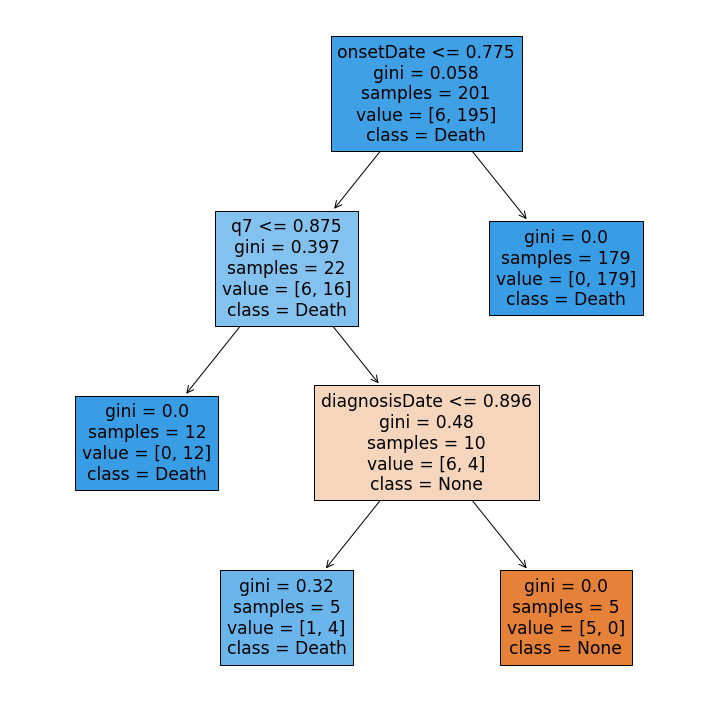



 ==================== SHAP ====================




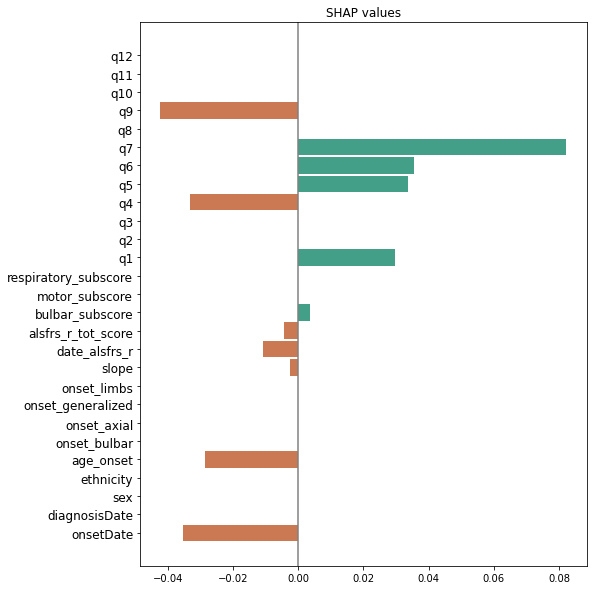



 ==================== LIME ====================




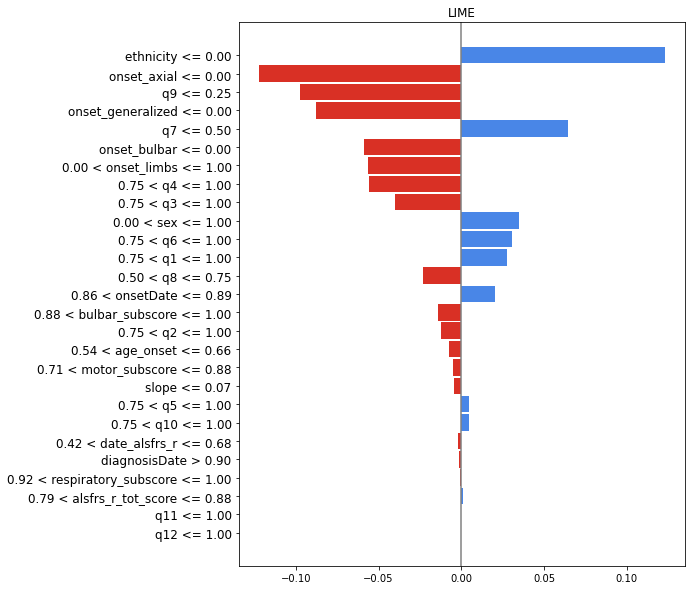

In [32]:
# declare the instance from the test set we want to explain
ind = 1
instance = X_test_nd[ind, :].reshape(1, X_test.shape[1])

# save the predicted label for the instance according to the current classifier
instance_pred_y = (v_clf.predict_proba(instance)[:,1] >= classifier_thr[k_clf]).astype(int)

# cumbersome line to print the example nicely
display(pd.DataFrame(data=[np.concatenate([instance.flatten(),instance_pred_y],dtype=object)],
                     columns=np.concatenate([feature_names,["pred_label"]],dtype=object)))

print(f"Predicted class:{instance_pred_y}")
print(f"True class:{y_test.iloc[ind]}")

## ARAUCANA
print("\n\n ==================== ARAUCANA ====================\n\n")

# build xai tree to explain the instance classification
xai_tree = araucanaxai.run(x_target=instance, y_pred_target=instance_pred_y,
                           x_train=X_train_nd, feature_names=feature_names,
                           cat_list=iscat, oversampling=None, max_depth=3, neighbourhood_size=200,
                           predict_fun= v_clf.predict)
from sklearn import tree
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(xai_tree['tree'], feature_names=feature_names, filled=True, class_names=["None","Death"])
plt.tight_layout()
plt.show()

## SHAP
print("\n\n ==================== SHAP ====================\n\n")

explainer = shap.Explainer(v_clf.predict_proba, np.median(X_test, axis=0).reshape(1, X_test.shape[1]))
shap_val = explainer(instance) 
base_values = shap_val.base_values
shap_values = shap_val.values

labels = feature_names
x = np.arange(len(labels))
w=0.9
fig, ax = plt.subplots(figsize=(8,10))
vals = shap_val[0].values[:,1]
bars = plt.barh(x, vals, label='SHAP', height=w, color= ['#449F89' if i else '#CA7952' for i in vals > 0])
plt.axvline(x=0, ymin=0, ymax=1, color='grey')
ax.set_yticks(x)
ax.set_yticklabels(labels, fontsize=12)
plt.title('SHAP values')
plt.show()

## LIME
print("\n\n ==================== LIME ====================\n\n")

explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_nd, feature_names = feature_names)
exp = explainer_lime.explain_instance(data_row=X_test_nd[ind, :], 
                                      predict_fn=v_clf.predict_proba,
                                      num_features=X.shape[1],                # ********* <<< DEBUG, replace with X.shape[1] >>> **********
                                      top_labels=1)

exp_list = exp.as_list()
vals = [x[1] for x in exp_list]
names = [x[0] for x in exp_list]
vals.reverse()
names.reverse()
colors = ['#4986E7' if x > 0 else '#D93025' for x in vals]
x = np.arange(len(labels))
w=0.9
fig, ax = plt.subplots(figsize=(8,10))
bars = plt.barh(x, vals, label='LIME', height=w, color= colors)
plt.axvline(x=0, ymin=0, ymax=1, color='grey')
ax.set_yticks(x)
ax.set_yticklabels(names, fontsize=12)
plt.title('LIME')
plt.show()

## Overall Metrics

**ARAUCANA** 

time
- Classifier  GB : time =  13.534106731414795
- Classifier  RF : time =  48.42930579185486
- Classifier  LR : time =  9.621516227722168
- Classifier  NN : time =  12.33416485786438

fidelity
- Classifier  GB : fidelity =  [1.]
- Classifier  RF : fidelity =  [1.]
- Classifier  LR : fidelity =  [1.]
- Classifier  NN : fidelity =  [1.]

identity
- Classifier GB : identity = na
- Classifier RF : identity = na
- Classifier LR : identity = na
- Classifier NN : identity = na

separability
- Classifier GB : separability =  0.034261030951540185 ( 4172 equals out of 121771 )
- Classifier RF : separability =  8.21213589442478e-06 ( 1 equals out of 121771 )
- Classifier LR : separability =  0.08295899680547913 ( 10102 equals out of 121771 )
- Classifier NN : separability =  0.0014863965968908853 ( 181 equals out of 121771 )

**SHAP**

time
- Classifier  GB : time =  0.01359415054321289
- Classifier  RF : time =  7.781444072723389
- Classifier  LR : time =  4.610779047012329
- Classifier  NN : time =  4.829805374145508

fidelity
- Classifier  GB : fidelity =  1
- Classifier  RF : fidelity =  1
- Classifier  LR : fidelity =  1
- Classifier  NN : fidelity =  1

identity
- Classifier GB : identity = na
- Classifier RF : identity = na
- Classifier LR : identity = na
- Classifier NN : identity = na

separability
- Classifier GB : separability =  0.0005912737843985842 ( 72 equals out of 121771 )
- Classifier RF : separability =  0.0 ( 0 equals out of 121771 )
- Classifier LR : separability =  0.0 ( 0 equals out of 121771 )
- Classifier NN : separability =  0.0 ( 0 equals out of 121771 )

**LIME**

time
- Classifier  GB : time =  484.8183653354645
- Classifier  RF : time =  539.5164840221405
- Classifier  LR : time =  480.4308581352234
- Classifier  NN : time =  484.91470646858215

fidelity
- Classifier  GB : fidelity =  0.9939271255060729
- Classifier  RF : fidelity =  0.9979757085020243
- Classifier  LR : fidelity =  0.9959514170040485
- Classifier  NN : fidelity =  0.9979757085020243

identity
- Classifier GB : identity =  na
- Classifier RF : identity =  na
- Classifier LR : identity =  na
- Classifier NN : identity =  na

separability
- Classifier GB : separability =  0.0 ( 0 equals out of 121771 )
- Classifier RF : separability =  0.0 ( 0 equals out of 121771 )
- Classifier LR : separability =  0.0 ( 0 equals out of 121771 )
- Classifier NN : separability =  0.0 ( 0 equals out of 121771 )

### **ARAUCANA**

In [127]:
#ARAUCANA EXPLAINER
def run_auracana(X_test, feature_names, cat_list, X_train, nsize, oversampling, oversampling_size, classifiers):
    xai_dict = dict(zip(list(classifiers.keys()), [[], [], [], []]))
    fidelity_dict = {}
    times = {}
    # for each classifier
    for k_clf, v_clf in classifiers.items():
        xai_start = time.time()
        fidelity_list = []
        fidelity_fail_count = 0
        # for each instance of the test set
        for i in tqdm(range(X_test.shape[0])):
            # declare the instance from the test set we want to explain
            instance = X_test[i, :].reshape(1, X_test.shape[1])
            # save the predicted label for the instance according to the current classifier
            instance_pred_y = (v_clf.predict_proba(instance)[:,1] >= classifier_thr[k_clf]).astype(int)
            # build xai tree to explain the instance classification
            try:
                xai_tree = araucanaxai.run(x_target=instance, y_pred_target=instance_pred_y,
                                           x_train=X_train, feature_names=feature_names,
                                           cat_list=cat_list, oversampling=oversampling, oversampling_size = oversampling_size,
                                           predict_fun= lambda instance:(v_clf.predict_proba(instance)[:,1] >= classifier_thr[k_clf]).astype(int), 
                                           neighbourhood_size=nsize)
                xai_dict[k_clf].append(xai_tree)
                #fidelity online check 
                if xai_tree['tree'].predict(instance) != instance_pred_y:
                  fidelity_fail_count += 1
                  if fidelity_fail_count == 100:
                    warnings.warn("Warning...........divergent predictions between explainer and original model")
                fidelity_list.append((xai_tree['tree'].predict(instance) == instance_pred_y).astype(int))
            except Exception as e:
                print(e)
                xai_dict[k_clf].append(None)
                fidelity_list.append(None)
                continue
        if len([x for x in fidelity_list if x != None]) != 0:
            fidelity_dict[k_clf] = sum([x for x in fidelity_list if x != None]) / len([x for x in fidelity_list if x != None])
        else:
            fidelity_dict[k_clf] = None
        times[k_clf]=time.time() - xai_start
    return {"fidelity": fidelity_dict, "test": xai_dict, "time": times}

In [128]:
# Function to compare explaination
def exp_similarity_trees(tree_a, tree_b):
    feat_a = tree_a.tree_.feature.copy()
    feat_b = tree_b.tree_.feature.copy()
    n = min(len(feat_a), len(feat_b))       # if different len, trim the longer
    feat_a = feat_a[0:n]
    feat_b = feat_b[0:n]
    return sum((feat_a == feat_b).astype(int)) / n

# FIDELITY: concordance of the predictions between the XAI proxy model and the complex model

def check_fidelity(araucana_xai):
  for c in classifier_dict.keys():
    print('- Classifier ', c, ': fidelity = ', araucana_xai["fidelity"][c])

# IDENTITY: if there are 2 identical instances, they must have identical explanations

def check_identity(X_test, araucana_xai):
  iDup = np.where(X_test.duplicated(keep=False))[0]  # instances in test which are duplicated
  xai_dup = []
  dup = []
  for couple in list(combinations(iDup, 2)):
    check = (X_test.iloc[couple[0],] == X_test.iloc[couple[1],]).all()
    if check:
      dup.append(couple)
  for c in classifier_dict.keys():
    if len(dup)!=0:
      right = 0
      for d in dup:
        xai1 = araucana_xai["test"][c][d[0]]['tree']
        xai2 = araucana_xai["test"][c][d[1]]['tree']
        s = exp_similarity_trees(xai1, xai2)
        if s==1:
          right += 1
      score = right/len(dup)
      print('- Classifier', c, ': identity = ', score)
    else:
      print('- Classifier', c, ': identity = na')



# SEPARABILITY: if there are 2 dissimilar instances, they must have dissimilar explanations

def check_separability(X_test_nd, araucana_xai):
  combs = list(combinations(range(len(X_test_nd)), 2))
  for c in classifier_dict.keys():
    wrong = 0
    for couple in combs:
        xai1 = araucana_xai["test"][c][couple[0]]['tree']
        xai2 = araucana_xai["test"][c][couple[1]]['tree']
        s = exp_similarity_trees(xai1, xai2)
        if s==1:
            wrong += 1
    total = len(combs)
    score = wrong/total
    print('- Classifier', c, ': separability = ', score, "(",wrong, 'equals out of',total,")")



**Metrics on Test Set**

In [129]:
nratio = 0.25 # neighborhood size expressed as a portion of training size
os_method = None # Possible values = [None,"smote", "uniform", "non-uniform"]
os_size = 0 # number of new samples to be generated with oversampling
nsize = int(X_train.shape[0] * nratio)

araucana_xai = run_auracana(X_test=X_test_nd, cat_list=iscat, feature_names=feature_names,
                            X_train=X_train_nd, nsize=nsize, oversampling=os_method, oversampling_size = os_size,
                            classifiers = classifier_dict)

print('\ntime')
for c in classifier_dict.keys():
  print('- Classifier ', c, ': time = ', araucana_xai["time"][c])

print('\nfidelity')
check_fidelity(araucana_xai)

print('\nidentity')
check_identity(X_test, araucana_xai)

print('\nseparability')
check_separability(X_test_nd, araucana_xai)

100%|██████████| 494/494 [00:12<00:00, 40.13it/s]



time
- Classifier  GB : time =  13.534106731414795
- Classifier  RF : time =  48.42930579185486
- Classifier  LR : time =  9.621516227722168
- Classifier  NN : time =  12.33416485786438

fidelity
- Classifier  GB : fidelity =  [1.]
- Classifier  RF : fidelity =  [1.]
- Classifier  LR : fidelity =  [1.]
- Classifier  NN : fidelity =  [1.]

identity
- Classifier GB : identity = na
- Classifier RF : identity = na
- Classifier LR : identity = na
- Classifier NN : identity = na

separability
- Classifier GB : separability =  0.034261030951540185 ( 4172 equals out of 121771 )
- Classifier RF : separability =  8.21213589442478e-06 ( 1 equals out of 121771 )
- Classifier LR : separability =  0.08295899680547913 ( 10102 equals out of 121771 )
- Classifier NN : separability =  0.0014863965968908853 ( 181 equals out of 121771 )


### **SHAP**

In [130]:
#SHAP EXPLAINER

def run_shap(X_test, classifiers):
    xai_dict = dict(zip(list(classifiers.keys()), [[], [], []])) 
    fidelity_dict = {}
    times = {}
    # for each classifier
    for k, v in classifiers.items():
      start = time.time()
      #For Logistic Regression, we need to use shap.Explainer
      if k=='LR' or k=='NN':
        explainer = shap.Explainer(v.predict_proba, np.median(X_test, axis=0).reshape(1, X_test.shape[1]))
        shap_val = explainer(X_test) 
        shap_values = shap_val.values
      #For Random Forest and Gradient Boosting, we can use shap.TreeExplainer
      else:
        explainer = shap.TreeExplainer(v)
        shap_values = explainer.shap_values(X_test)
      if k=='RF':
        shap_values = shap_values[1]
      xai_dict[k] = shap_values
      times[k] = time.time()-start
      fidelity_dict[k] = 1 #by default, not a local explainer
    return {"fidelity": fidelity_dict, "test": xai_dict, "time": times}

**Metrics on Test Set**

In [131]:
shap_xai = run_shap(X_test=X_test_nd, classifiers = classifier_dict)

print('\ntime')
for c in classifier_dict.keys():
  print('- Classifier ', c, ': time = ', shap_xai["time"][c])


time
- Classifier  GB : time =  0.01359415054321289
- Classifier  RF : time =  7.781444072723389
- Classifier  LR : time =  4.610779047012329
- Classifier  NN : time =  4.829805374145508
- Classifier  GB : time =  0.01359415054321289
- Classifier  RF : time =  7.781444072723389
- Classifier  LR : time =  4.610779047012329
- Classifier  NN : time =  4.829805374145508


In [132]:
# Function to compare explaination (oversimplified, we only need to check if they are equal or not at the moment)
def exp_similarity_shap(shap_vals_a, shap_vals_b):
    is_equal = np.array_equal(shap_vals_a,shap_vals_b)
    return 1 if is_equal else 0

# FIDELITY (1 by default, not a local explainer)

print('\nfidelity')
for c in classifier_dict.keys():
  print('- Classifier ', c, ': fidelity = ', shap_xai["fidelity"][c])

# IDENTITY

print('\nidentity')
iDup = np.where(X_test.duplicated(keep=False))[0]  # instances in test which are duplicated
xai_dup = []
dup = []
for couple in list(combinations(iDup, 2)):
  check = (X_test.iloc[couple[0],] == X_test.iloc[couple[1],]).all()
  if check:
    dup.append(couple)

for c in classifier_dict.keys():
  if len(dup)!=0:
    right = 0
    for d in dup:
      s = exp_similarity_shap(shap_xai["test"][c][d[0]], shap_xai["test"][c][d[1]])
      if s==1:
        right += 1
    score = right/len(dup)
    print('- Classifier', c, ': identity = ', score)
  else:
   print('- Classifier', c, ': identity = na')

# SEPARABILITY

print('\nseparability')
combs = list(combinations(range(len(X_test_nd)), 2))
for c in classifier_dict.keys():
  wrong = 0
  for couple in combs:
      s = exp_similarity_shap(shap_xai["test"][c][couple[0]], shap_xai["test"][c][couple[1]])
      if s==1:
          wrong += 1
  total = len(combs)
  score = wrong/total
  print('- Classifier', c, ': separability = ', score, "(",wrong, 'equals out of',total,")")


fidelity
- Classifier  GB : fidelity =  1
- Classifier  RF : fidelity =  1
- Classifier  LR : fidelity =  1
- Classifier  NN : fidelity =  1

identity
- Classifier GB : identity = na
- Classifier RF : identity = na
- Classifier LR : identity = na
- Classifier NN : identity = na

separability
- Classifier GB : separability =  0.0005912737843985842 ( 72 equals out of 121771 )
- Classifier RF : separability =  0.0 ( 0 equals out of 121771 )
- Classifier LR : separability =  0.0 ( 0 equals out of 121771 )
- Classifier NN : separability =  0.0 ( 0 equals out of 121771 )


### **LIME**

In [133]:
#LIME EXPLAINER

def run_lime(X, lime_explainer, classifiers, top_labels=1):
    """
    Run LIME explainer

    :param X: data
    :param lime_explainer: LIME explainer obj
    :param classifiers: dictionary with classifiers names and corresponding objects
    :param top_labels: default to label 1
    """
    classifier2lime_test = {}          #explainations for test set
    classifier2lime_fidelity = {}      #fidelity 
    classifier2lime_time = {}          #time
    for k, v in classifiers.items():
      
        fid = []
        exp_list = []
        lime_start = time.time()
        for i in tqdm(range(X.shape[0])):
            instance = X[i, :].reshape(1, X.shape[1])
            #instance_pred_y = v.predict(instance)
            instance_pred_y = (v.predict_proba(instance)[:,1] >= classifier_thr[k]).astype(int)
            exp = lime_explainer.explain_instance(data_row=X[i, :],
                                                  predict_fn=v.predict_proba,
                                                  num_features=X.shape[1],                # ********* <<< DEBUG, replace with X.shape[1] >>> **********
                                                  top_labels=top_labels)
            fid.append(((exp.predict_proba[1] >= 0.5).astype(int) == instance_pred_y))
            exp_list.append(exp)
        classifier2lime_test[k] = exp_list
        classifier2lime_fidelity[k] = fid
        classifier2lime_time[k] = time.time() - lime_start
    return ({"fidelity": classifier2lime_fidelity,
             "test": classifier2lime_test,
             "time": classifier2lime_time})

**Metrics on Test Set**

In [134]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_nd)
lime_xai = run_lime(X=X_test_nd, lime_explainer=explainer_lime, classifiers=classifier_dict, top_labels=1)

print('\ntime')
for c in classifier_dict.keys():
  print('- Classifier ', c, ': time = ', lime_xai["time"][c])

100%|██████████| 494/494 [08:04<00:00,  1.02it/s]


time
- Classifier  GB : time =  484.8183653354645
- Classifier  RF : time =  539.5164840221405
- Classifier  LR : time =  480.4308581352234
- Classifier  NN : time =  484.91470646858215


In [135]:
# Function to compare explaination (oversimplified, we only need to check if they are equal or not at the moment)
def exp_similarity_lime(lime_a, lime_b):
    is_equal = np.array_equal(lime_a,lime_b)
    return 1 if is_equal else 0

def exp_fn_blk(xtest, exp_list):
    exp1 = []
    for i in range(len(xtest)):
        exp1.append(exp_list[i].as_map()[exp_list[i].available_labels()[0]])
    return np.array(exp1)

# FIDELITY (1 by default, not a local explainer)

print('\nfidelity')
for c in classifier_dict.keys():
  bool_array = lime_xai["fidelity"][c]
  f = len([x for x in bool_array if x == True]) / len(bool_array)
  print('- Classifier ', c, ': fidelity = ', f)

# IDENTITY

print('\nidentity')
iDup = np.where(X_test.duplicated(keep=False))[0]  # instances in test which are duplicated
xai_dup = []
dup = []
for couple in list(combinations(iDup, 2)):
  check = (X_test.iloc[couple[0],] == X_test.iloc[couple[1],]).all()
  if check:
    dup.append(couple)

for c in classifier_dict.keys():
  exp_fn_wrap = lambda x: np.array(exp_fn_blk(x, lime_xai["test"][c]))
  exp = exp_fn_wrap(X_test_nd)
  if len(dup)!=0:
    right = 0
    for couple in dup:
      s = exp_similarity_lime(exp[couple[0]],exp[couple[1]])
      if s==1:
        right = right + 1
    total = len(combs)
    score = right/total
  else:
    score = "na"  
  print('- Classifier', c, ': identity = ', score)


# SEPARABILITY

print('\nseparability')
combs = list(combinations(range(len(X_test_nd)), 2))
for c in classifier_dict.keys():
  wrong = 0
  exp_fn_wrap = lambda x: np.array(exp_fn_blk(x, lime_xai["test"][c]))
  exp = exp_fn_wrap(X_test_nd)
  for couple in combs:
      s = exp_similarity_lime(exp[couple[0]],exp[couple[1]])
      if s==1:
          wrong += 1
  total = len(combs)
  score = 100*abs(wrong)/total
  print('- Classifier', c, ': separability = ', score, "(",wrong, 'equals out of',total,")")


fidelity
- Classifier  GB : fidelity =  0.9939271255060729
- Classifier  RF : fidelity =  0.9979757085020243
- Classifier  LR : fidelity =  0.9959514170040485
- Classifier  NN : fidelity =  0.9979757085020243

identity
- Classifier GB : identity =  na
- Classifier RF : identity =  na
- Classifier LR : identity =  na
- Classifier NN : identity =  na

separability
- Classifier GB : separability =  0.0 ( 0 equals out of 121771 )
- Classifier RF : separability =  0.0 ( 0 equals out of 121771 )
- Classifier LR : separability =  0.0 ( 0 equals out of 121771 )
- Classifier NN : separability =  0.0 ( 0 equals out of 121771 )
